In [97]:
import cv2
from cv2 import threshold
import numpy as np
import sys
import os
import json
from torchvision import models
from tqdm import tqdm
from pytorch3d.renderer import look_at_view_transform
from math import ceil
import torch
from pytorch3d.io import load_obj, load_ply
from scipy.spatial.transform import Rotation as scipy_rot
from matplotlib import pyplot as plt
from probabilistic_formulation.tests.test_factors_lines import create_k3d_plot
import copy
import ipyplot

%load_ext autoreload
%autoreload 2

from leveraging_geometry_for_shape_estimation.keypoint_matching.get_matches_3d import load_information_depth_camera,create_pixel_bearing,pb_and_depth_to_wc
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.pose import init_Rs,init_Ts,get_pb_real_grid,get_R_limits,get_T_limits, create_pose_info_dict, check_gt_pose_in_limits, get_nearest_pose_to_gt
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.ground_plane import get_model_to_infos,sample_Ts_ground_plane,filter_Ts
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.translation_from_lines_v7 import *
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.visualise_T_factors import plot_lines_T_correct_visualisation, get_pointsize_from_Ts
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.translation_from_lines_visualise_v1 import visualise_single_example
from leveraging_geometry_for_shape_estimation.segmentation.meshrcnn_vis_tools import draw_boxes
from leveraging_geometry_for_shape_estimation.utilities.write_on_images import draw_lines
from leveraging_geometry_for_shape_estimation.data_conversion.create_dirs import dict_replace_value

from probabilistic_formulation.utilities import create_all_possible_combinations,get_uvuv_p_from_superpoint,create_all_possible_combinations_uvuv_p_together
from probabilistic_formulation.factors.factors_T.factors_lines_multiple_T import get_factor_reproject_lines_multiple_T, get_factor_reproject_lines_multiple_T_threshold, get_factor_reproject_lines_multiple_T_with_Scale
from probabilistic_formulation.factors.factors_T.bbox import get_factor_bbox_multiple_T
from probabilistic_formulation.tests.test_reproject_lines import load_lines_2D,load_lines_3D,get_cuboid_line_dirs_3D,plot_lines_T,plot_bbox, plot_points_T

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
# exp_path = '/scratches/octopus_2/fml35/experiments/leveraging_geometry_for_shape/exp_208_debug_bbox'
# exp_path = '/scratches/octopus_2/fml35/experiments/leveraging_geometry_for_shape/exp_219_debug'
exp_path = '/scratches/octopus_2/fml35/experiments/leveraging_geometry_for_shape/exp_255_bbox_rgb_lines_epoch_150'
global_info = exp_path + '/global_information.json'
with open(global_info,'r') as f:
    global_config = json.load(f)


# global_config["pose_and_shape_probabilistic"]["reproject_lines"]["signal"] = "lines_classifier"
# global_config["general"]["use_existing"] = []



# global_config["pose_and_shape_probabilistic"]["reproject_lines"]["network_path"] = "/scratch2/fml35/experiments/classify_T_from_lines_02/date_2022_03_30_time_17_52_49_bbox_augmentation_ADAM/saved_models/last_epoch.pth"
# global_config["pose_and_shape_probabilistic"]["reproject_lines"]["network_path"] = "/scratch2/fml35/experiments/classify_T_from_lines_02/date_2022_04_06_time_16_36_29_black_lines_bbox_no_gt_z_hard_data_lr_halve/saved_models/last_epoch.pth"
# global_config["pose_and_shape_probabilistic"]["reproject_lines"]["classifier_exp_path"] = "/scratch2/fml35/experiments/classify_T_from_lines_02/date_2022_04_06_time_16_36_29_black_lines_bbox_no_gt_z_hard_data_lr_halve"
# global_config["pose_and_shape_probabilistic"]["reproject_lines"]["classifier_epoch"]= 'last'

global_config["pose_and_shape_probabilistic"]["pose"] = {
                    "gt_z": "False",
                    "gt_R": False,
                    'sample_around_gt_z': True,
                    "tilt":{"range": 20,"steps": 20},
                    "elev":{"range": 45,"steps": 45},
                    "azim":{"range": 45,"steps": 45},
                    "x":{"range": 0.5,"steps": 6},
                    "y":{"range": 0.5,"steps": 6},
                    "z":{"range": 0.5,"steps": 6}
                }
# print(global_config["pose_and_shape_probabilistic"]["pose"])

global_config["general"]["gpu"] = 2

In [99]:

global_config = dict_replace_value(global_config,'/scratch/fml35/','/scratches/octopus/fml35/')
global_config = dict_replace_value(global_config,'/scratch2/fml35/','/scratches/octopus_2/fml35/')

target_folder = global_config["general"]["target_folder"]
model_to_infos = get_model_to_infos()

# scene0011_01-000400_00_000_03_chair
# name = 'scene0011_01-000400_00_000_03.json'
# name = 'scene0011_00-001200_01_000_02.json'
# name = 'scene0025_00-001400_00_000_01.json'
# name = 'scene0430_00-000400_01_000_00.json'
# name = 'scene0598_01-000400_00_000_00.json'
# name = 'scene0011_00-001900_03_000_00.json'
# name = 'scene0011_01-000200_00_000_00.json' # bug with mapping ?? no all correct
# name = 'scene0011_00-000000_00_000_00.json'
# name = 'scene0011_00-001200_01_000_00.json'
# name = 'scene0011_00-002100_03_000_00.json'
# name = 'scene0665_01-000400_02_000_00.json'






In [100]:
cfg_1 = copy.deepcopy(global_config)
cfg_2 = copy.deepcopy(global_config)
cfg_2["pose_and_shape_probabilistic"]["reproject_lines"]["signal"] = "lines"


In [101]:
gt_T = [0.5446935880177487, -0.2386588813253322, 1.9058292932368883]

In [102]:
configs = [cfg_1]
# line_indices_2ds = [None,[1,4,24]]
line_indices_2ds = [None,None]
line_indices_3ds = [None,None]
use_gt_retrievals = [False,False]
use_gt_Rs = [False,False]
# specific_Ts = [[[ 0.1045, -0.0162,  1.4871]],None]
# specific_Ts = [[[-0.1486571784928421, 0.010539434249897894, 1.5424885361165246],[-0.3,0.0,3.0]],None]
# specific_Ts = [[[-0.3,0.0,3.0]],None]
# specific_Ts = [[gt_T + np.array([0,0,0.1*i]) for i in range(4,5)]]
specific_Ts = [None]
print(specific_Ts)
# names = ['scene0046_02-000500_00_000_02.json','scene0030_00-001300_00_000_00.json']
# names = ['scene0300_00-000500_00_000_00.json']

names = ['scene0011_00-000000_00_000_00.json']

[None]


In [103]:
classifier_config = load_json(global_config["pose_and_shape_probabilistic"]["reproject_lines"]["classifier_exp_path"] + '/code/leveraging_geometry_for_shape_estimation/probabilistic_pose_and_shape/train_pose_classifier_from_lines/config.json')
if global_config["general"]["run_on_octopus"] == 'False':
        classifier_config = dict_replace_value(classifier_config,'/scratch/fml35/','/scratches/octopus/fml35/')
        classifier_config = dict_replace_value(classifier_config,'/scratch2/fml35/','/scratches/octopus_2/fml35/')
network = load_classifier(cfg_1,classifier_config)


cuda:2
load classifier
loaded classifier


In [104]:
outputs=[]
img_names = ['selected_T_selected_S','closest_T_closest_S','closest_T_selected_S','selected_T_closest_S']
# pose_information,imgs,Ts,factors,area_accepted_all_Ts
for i in range(len(configs)):
    pose_information,_,factor_output = get_pose_single_example(configs[i],names[i],model_to_infos,line_indices_2d=line_indices_2ds[i],line_indices_3d=line_indices_3ds[i],use_gt_retrieval=use_gt_retrievals[i],use_gt_R=use_gt_Rs[i],specific_Ts=specific_Ts[i],network=network,classifier_config=classifier_config)
    
    # eval_results = eval_factors(factor_output,np.array(pose_information["gt_T"]))
    # print(eval_results)
    imgs,img_annotations = visualise_single_example(global_config,names[i],factor_output,img_names)
    # imgs,img_annotations = None,None
    eval_results = None
    output = (pose_information,factor_output,imgs,img_annotations,eval_results)
    outputs.append(output)



T.shape torch.Size([216, 3])
S.shape torch.Size([125, 3])
torch.Size([27000, 96, 128, 3])


In [105]:
print(pose_information)

{'predicted_r': [[-0.8212821534921277, 0.015090200624336553, -0.570322636934964], [0.2835329016368533, 0.8782592337652242, -0.3850581929988092], [0.49508051672906694, -0.47794665408520126, -0.7255772032003496]], 'predicted_t': [-0.24865718185901642, -0.08946056663990021, 2.0424885749816895], 'predicted_s': [1.75, 1.75, 1.75], 'lines_3D_available': True, 'lines_2D_available': True, 'indices': [0], 'factor': 0.9745792150497437, 'in_limits': 'False', 'gt_R': [[-0.9159698900102662, 0.016938140008283795, -0.40088787180113106], [0.2236762453545927, 0.8510223077031929, -0.47511021501598383], [0.33311789854346746, -0.5248555586344326, -0.7833002896753601]], 'gt_T': [-0.1486571784928421, 0.010539434249897894, 1.5424885361165246], 'gt_S': [1.0585635399964661, 1.3518562166309844, 0.9758376251007228], 'gt_angles': [-178.94060517130248, -23.633724475667396, 148.76112831452724], 'best_R_possible': [-178.94746842105263, -34.77282727272727, 152.04535454545453], 'best_T_possible': [-0.24865717849284208


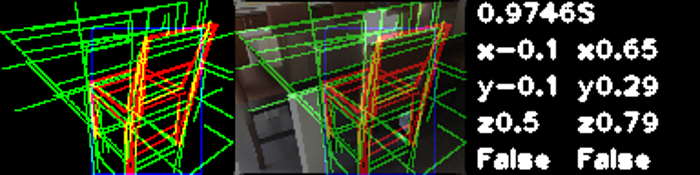


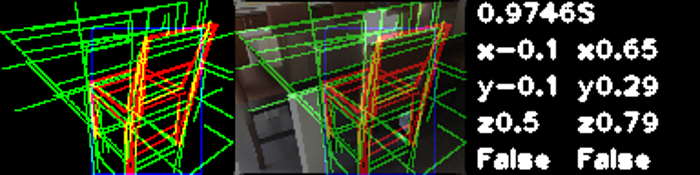

In [106]:
# ipyplot.plot_images([outputs[0][1][0],outputs[1][1][0]], max_images=20, img_width=600)
ipyplot.plot_images([output[2][0] for output in outputs], max_images=20, img_width=700)
# ipyplot.plot_images([imgs[0][i] for i in range(20)], max_images=20, img_width=120)

In [107]:
# all_2d_to_all_3d = outputs[0][1]["all_factors_T_2d_3d_selected_T"]


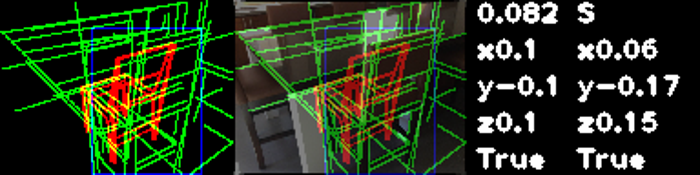


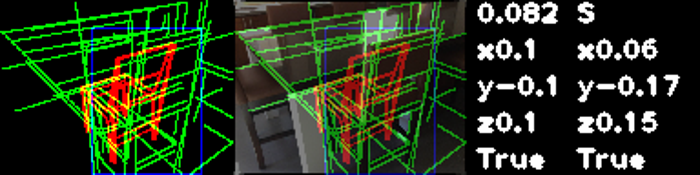


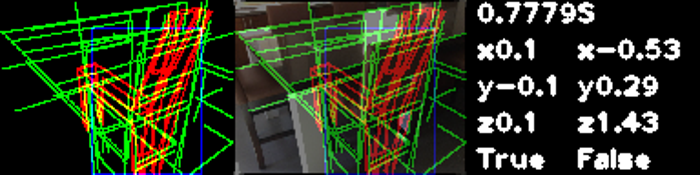


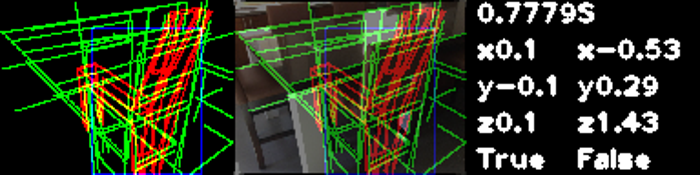


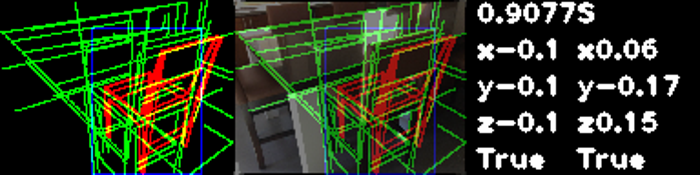


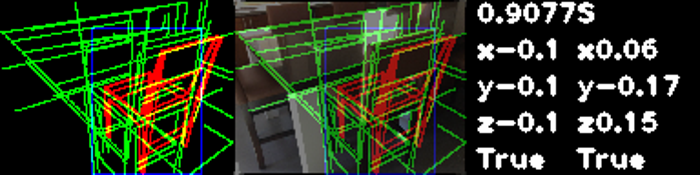

In [108]:
# CLOSEST TO GT TS
ipyplot.plot_images([output[2][1] for output in outputs], max_images=20, img_width=700)
ipyplot.plot_images([output[2][2] for output in outputs], max_images=20, img_width=700)
ipyplot.plot_images([output[2][3] for output in outputs], max_images=20, img_width=700)

In [109]:
# area_accepted_gt = outputs[0][1]['all_accepted_T_2d_closest_gt']
# all_factors_T_2d_closest_gt = outputs[0][1]['all_factors_T_2d_closest_gt']

# def get_threshold_for_max_area(area_accepted_gt,all_factors_T_2d_closest_gt,w=1296):
#     max_area = np.max(all_factors_T_2d_closest_gt[area_accepted_gt])
#     return max_area ** 0.5 / w

# threshold = get_threshold_for_max_area(area_accepted_gt,all_factors_T_2d_closest_gt)
# print(threshold)

In [117]:
threshold = 0.0

# for key in outputs[0][1]:
#     print(key)

# for Classifier

indices = [factor_output['selected_T_selected_S']['S_index'],factor_output['closest_T_closest_S']['S_index'],factor_output['selected_T_selected_S']['T_index'],factor_output['closest_T_closest_S']['T_index']]

names = ['T for selected S','T for closest S','S for selected T','S for closest T']

for i in range(len(configs)):
    for j in range(4):
        print(names[j])
        pose_information,factor_output,imgs,img_annotations,_ = outputs[i]
        Ts = np.array(factor_output["T"])
        Ss = np.array(factor_output["S"])
        factor = np.array(factor_output["factors"]).reshape((Ts.shape[0],Ss.shape[0]))
        

        # factor_selected = factor[factor_output[name]['T_index'],:]
        # create_k3d_plot(Ss[factor_selected > threshold],factor_selected[factor_selected > threshold],np.array(pose_information['gt_S']),point_size=get_pointsize_from_Ts(Ss),highlight='max',relative_highlight_size=1)
        if j < 2:
            factor_selected = factor[:,indices[j]]
            create_k3d_plot(Ts[factor_selected > threshold],factor_selected[factor_selected > threshold],np.array(pose_information['gt_T']),point_size=get_pointsize_from_Ts(Ts),highlight='max',relative_highlight_size=1)
        else:
            factor_selected = factor[indices[j],:]
            create_k3d_plot(Ss[factor_selected > threshold],factor_selected[factor_selected > threshold],np.array(pose_information['gt_S']),point_size=get_pointsize_from_Ts(Ss),highlight='max',relative_highlight_size=1)


T for selected S


/home/mifs/fml35/environments/torch1.9/lib/python3.7/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  np.dtype(self.dtype).name))
/home/mifs/fml35/environments/torch1.9/lib/python3.7/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

T for closest S


Output()

S for selected T


Output()

S for closest T


Output()

In [111]:
# for BBOX
for i in range(len(configs)):
    pose_information,factor_output,imgs,img_annotations,_ = outputs[i]
    Ts = np.array(factor_output["T"])
    if i == 0:
        factor = np.array(factor_output["box_iou"])
    if i == 1:
        factor = np.array(factor_output["area_accepted_all_Ts"])
    create_k3d_plot(Ts,factor,np.array(pose_information['gt_T']),point_size=get_pointsize_from_Ts(Ts),highlight='max',relative_highlight_size=1)
    # print(factor)

KeyError: 'box_iou'

In [ ]:
for i in [1]:
    pose_information,factor_output,imgs,img_annotations,_ = outputs[i]
    # have zeros if not 
    Ts = np.array(factor_output["T"])
    area_accpeted_all_Ts = np.array(factor_output["area_accepted_all_Ts"])
    # print(Ts)
    create_k3d_plot(Ts,area_accpeted_all_Ts,np.array(pose_information['gt_T']),point_size=get_pointsize_from_Ts(Ts),highlight='min',relative_highlight_size=1)
    print(factor_output["area_accepted_all_Ts"])

/home/mifs/fml35/environments/torch1.9/lib/python3.7/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  np.dtype(self.dtype).name))
/home/mifs/fml35/environments/torch1.9/lib/python3.7/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

[43377.625 43377.625 43377.625 ... 43377.625 43377.625 43377.625]


In [ ]:
# in image x point left, y points up and z points into image
for i in [1]:
    pose_information,factor_output,imgs,img_annotations,_ = outputs[i]
    Ts = np.array(factor_output["T"])
    factors = np.array(factor_output["n_accepted_all_Ts"])
    create_k3d_plot(np.array(Ts),np.array(factors),np.array(pose_information['gt_T']),point_size=get_pointsize_from_Ts(Ts),relative_highlight_size=1.)

/home/mifs/fml35/environments/torch1.9/lib/python3.7/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  np.dtype(self.dtype).name))
/home/mifs/fml35/environments/torch1.9/lib/python3.7/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

In [ ]:
for i in range(len(configs)):
    pose_information,factor_output,imgs,img_annotations,_ = outputs[i]
    Ts = np.array(factor_output["T"])
    factors = np.array(factor_output["n_accepted_all_Ts"])

    mask_factors = np.array(factors) > 11.5
    factors = 1- mask_factors * 1
    create_k3d_plot(np.array(Ts),np.array(factors),np.array(pose_information['gt_T']),point_size=get_pointsize_from_Ts(Ts),relative_highlight_size=1)


Output()

In [ ]:
all_2d_to_all_3d = outputs[0][1]["all_factors_T_2d_3d_selected_T"]
print(all_2d_to_all_3d.shape)

(31, 65)
